# Ensemble learning
Ensemble learning uses the *wisdom of the crowd*, stating that aggregated answer is more accurate than an expert’s answer. Then, an *ensemble* is the group of predictors, which is learned by an *Ensemble method*. For example, a Random Forest is an ensemble of Decision Trees that can classify by voting.
## Voting Classifiers
The ***majority-vote*** classifier aggregates the votes of each diverse predictors, i.e., ***hard voting classifier***. This ensemble is mostly *strong learner* (with higher accuracy) even if formed by merely weak learner (just better than random guessing). E.g. accuracy of a VotingClassifier() was assessed by `accuracy_score()`, while their names are accessible in `.__class__.__name__.`. 

To get better accuracy, the predictors could be trained by different datasets, and their algorithms can be different and independent enough so that they do not make similar errors. E.g. 10 biased coins with 51% chance of coming up heads demonstrates the probability of heads if keep tossing (***law of large numbers***).

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [88]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)  # 10 series of biased coin tosses
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


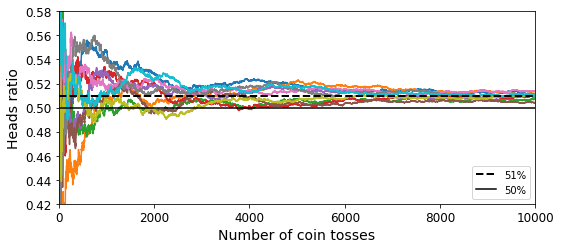

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                            

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Provided that `predict_proba()` is available for all the predictors, then sklearn can predict by averaging on them, i.e., ***soft voting***, which is implementable by `voting="soft"`. For example, in SVC use `probability=True`, using possibly expensive cross-validation to estimate the class, which may achieve higher accuracy.

In [16]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                            

In [17]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and pasting
If the predictors are trained on the random subsets of the dataset, and if the sampling is with replacement (i.e., the elements would be returned to their sets after training), it is **bagging** (AKA **bootstrap aggregating**), otherwise it is **pasting**. The ensemble can predict by an aggregation function, which normally is
- The statistical mode for classification or
- The average for regression.

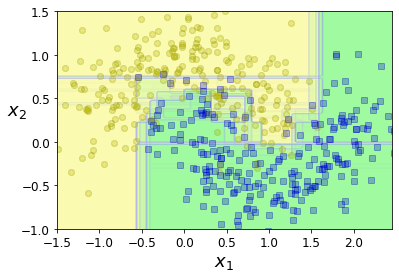

In [29]:
# Simplified concept of replacement:

plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### Bagging training
Bagging and pasting, which can be chosen by `bootstrap` option in `BaggingClassifier()` or `BaggingRegressor()`, can be trained in parallel, particularly in all available CPU cores by `n_jobs=-1`. They can be regularized by `n_estimators` and `max_samples`. The latter can refer to either the number of classifiers or relative number (a flout between 0.0 to 1.0). Soft voting is performed, if available.

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
print(accuracy_score(y_test, y_pred))

0.904


In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


------
Typically, aggression reduces both bias and variance, whereas the ensemble bias would be similar to those of the predictors, as the errors are similar, but the decision boundary is more regular. 

In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


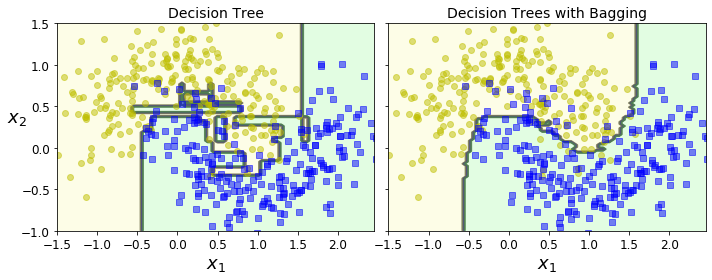

In [22]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-Bag (oob) evaluation


With bagging, the probability of not selecting large m elements is

\begin{equation}
\lim_{\mathit{m}\to\infty} {\left(\frac{\mathit{m}-1}{\mathit{m}}\right)^\mathit{m}=\mathit{exp}(-1)}\simeq\mathbf{63}.\mathbf{2}%
\end{equation}

The remaining average of 37% without sampling are called ***out-of-bag instances***, which can be used to evaluate the model as a validation set by `oob_score=True`. The result of oob evaluation and the decision functions on each class is available through `.oob_score_` and `.oob_decision_function_`, respectively. 

In [30]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [32]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred) # the evaluation is similar to the oob evaluation

0.912

In [31]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

For example, 68% probability of belonging to the positive class is found for the first training instance.

As all support `predict_proba()`, the decision functions are the probabilities.

In comparison to the bagging, it should slightly introduce more diversity, increasing the bias, while make the predictors less correlated, decreasing the variance.

### Feature sampling
Use `.max_features` and `.bootstrap_features` to perform random feature sampling similarly, which may result in slightly more predictor diversity (and bias) and lower variance. For this, use:
- ***Random Patches***: both of the training instances and features are sampled.
- ***Random Subspaces***: all the training instances are kept by `bootstrap=False` and `max_samples=1.0`, but simultaneously the features are sampled by`bootstrap_features=True` and `setting max_features` a value smaller than 1.

Such methods are useful in high-dimensional data (e.g., images).

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [24]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

`RandomForestClassifier()` or `RandomForestRegressor()` run bagging (or sometimes pasting) of Decision Trees more efficiently although some of the parameters are absent and unchangeable, e.g., `splitter="random"` and `max_samples=1.0`. Its algorithm only finds the optimum features by random sampling of features, which can increase the diversity and improve the model. 

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

----------
Random Forests are also handy for quick ***feature selection*** via `.feature_importances_` through assessing the average impurity reduction of features across all the trees’ nodes weighted by number of training samples of each node, i.e., node weights. As the feature importance values are scaled, their sum is 1.

In [27]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


petal length with 44% is the most important feature.

In [28]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [1]:
# Another e.g.

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

NameError: name 'np' is not defined

In [34]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


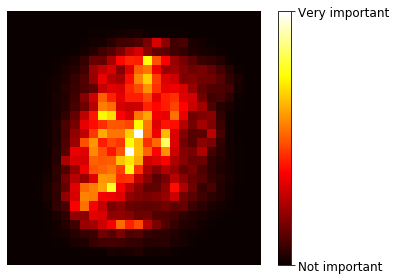

In [36]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### Extra-Trees
Utilize `ExtraTreesClassifier` and `ExtraTreesRegressor`, which are **Extremely Randomized Trees** ensembles, to make trees in the Random Forests even more random by application of the random thresholds. Comparing to Random Forests, they have a similar API with a higher bias and faster training, but the performance should be compared by cross-validation, because they are not easily comparable.

## Boosting
**Hypothesis boosting** is an ensemble method, combining the *weak predictors* that sequentially correct their predecessors, into a *strong predictor*.
### AdaBoost
**Adaptive Boosting** focuses on the training instances that makes the predecessor underfitted by a *weight update rule*. E.g. the weights of the misclassified instances got boosted gradually with different learning rates to demonstrate, somehow similar to GD which tweaks the parameters to minimize an objective function, it adds predictors for a similar optimization. Although the prediction is similar to the bagging and pasting algorithms updated by weights, but as it is, at best, partially parallelized, it cannot scale as well.

Saving figure boosting_plot


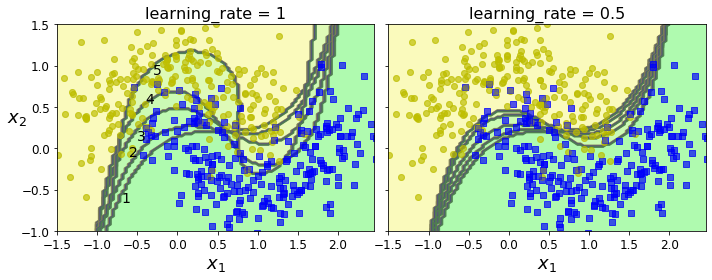

In [39]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

For the base classifier and each $i^{th}$ instance, the weight $w^{\left(i\right)}=1/m$ while for the others, they are multiplied by $exp\left(\alpha_j\right)$ if the instance of the $j^{th}$ predictor is misclassified, then normalized by $\sum_{i=1}^{m}w^{\left(i\right)}$. The predictor weight is

\begin{equation}
\alpha_j=\eta\ log\left(\frac{1-r_j}{r_j}\right)
\end{equation}

Where $\eta$ is the learning rate (defaults to 1) and $r_j$ is the weighted error rate, which can be updated by

\begin{equation}
r_j=\frac{{\begin{matrix}\sum_{i=1}^{m}w^{\left(i\right)}\\\left({\hat{y}}_j^{\left(i\right)}\neq y^{\left(i\right)}\right)\ \ \ \ \ \ \\\end{matrix}}}{\sum_{i=1}^{m}w^{\left(i\right)}}
\end{equation}

Therefore, a random predictor has zero weight and a less accurate one has a negative weight. Assuming k as different target values, the AdaBoost prediction for $N$ predictors is

\begin{equation}
\begin{matrix}\hat{y}\left(\mathbf{x}\right)=argmax\\\ \ \ \ \ \ \ \ \ \ \ \ \ k\\\end{matrix}\begin{matrix}\sum_{j=1}^{N}\alpha_j\\\left({\hat{y}}_j^\ \left(\mathbf{x}\right)=k\right)\ \ \ \\\end{matrix}
\end{equation}

In sklearn, for AdaBoost, utilize `AdaBoostRegressor()` and `AdaBoostClassifier()`.

E.g., a ***Decision Stump***, i.e., a Decision Tree with `max_depth=1`, was trained for the multiclass classification by `algorithm="SAMME.R"` (*SAMME* stands for *Stagewise Additive Modeling using a Multiclass Exponential* loss function and *R* stands for *Real*). If the `predict_proba()` is not available, then use `algorithm="SAMME"`. Finally, to avoid overfitting in AdaBoost ensembles, decrese `n_estimators`, or more strongly, regularize the base estimator.

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

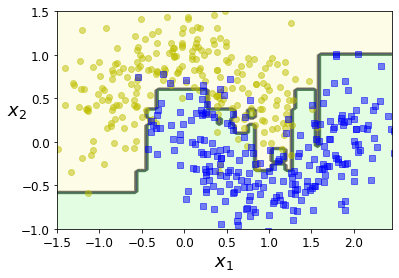

In [38]:
plot_decision_boundary(ada_clf, X, y)

Generally, for all of these objects, the attributes can be listed by `dir()` together with not `.startswith("_")` and `.endswith("_")`.

In [40]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

### Gradient boosting
As distinct from AdaBoost, which tweaks the instance weights, the **Gradient Boosting** iteratively fits the new predictor by the ***residual errors*** of the predecessor.

E.g., a **Gradient Tree Boosting**, or **Gradient Boosted Regression Trees (GBRT)**, which is the model with Decision Trees as the base predictors.

In [41]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [43]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

In [44]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


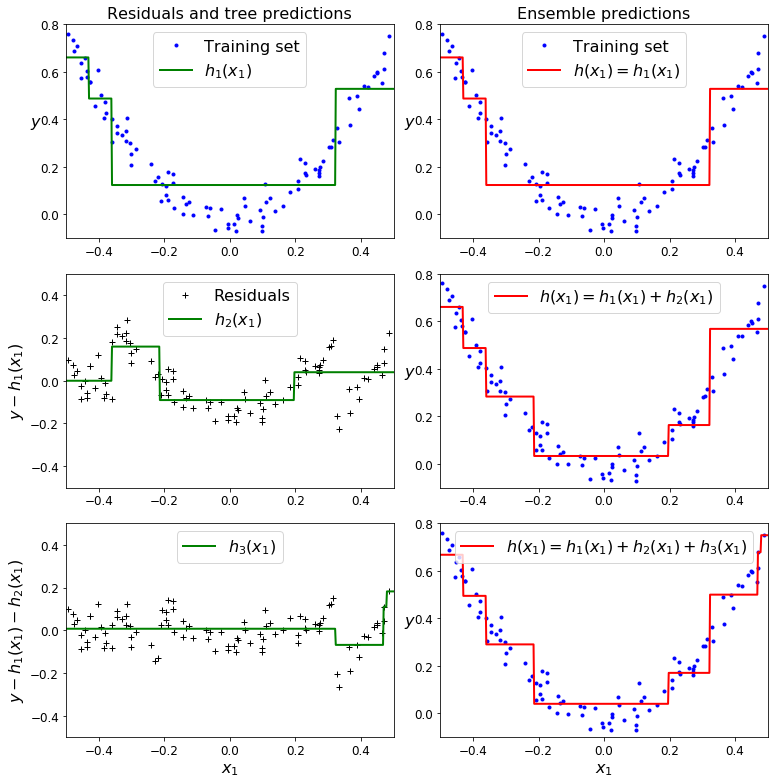

In [45]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

-----------
In sklearn, use `GradientBoostingRegressor()` for GBRT, which has the hyperparameters of RandomForestRegressor class to control the growth of the Decision Trees, e.g., `.max_depth` and `.min_samples_leaf` together with the other hyperparameters, e.g., `.n_estimators`. Generally, by reducing in `.learning_rate`, which scales the contributions of the trees, the predictions typically generalize better, i.e., ***shrinkage*** regularization, although more trees are then needed (not too many as may cause overfitting). The optimal number of trees can be found by early stopping through the `.staged_predict()` method, returning an iterator over the predictions made at each stage of the training.
#### Gradient Boosting with Early Stopping
`warm_start=True` can be used to gradually train the trees and to avoid training them completely in early stopping.  

In [49]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


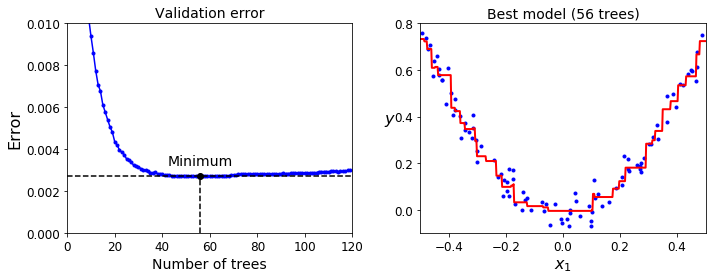

In [53]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [56]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [57]:
print(gbrt.n_estimators)

61


In [58]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


#### Stochastic Gradient Boosting
**Stochastic Gradient Boosting** can be implemented by the `subsample` hyperparameters, defining the fraction of dataset that can train each tree randomly, which may trade a higher bias but a lower variance. The other cost functions are controlled by the `loss` hyperparameter.

#### Extreme Gradient Boosting
The **XGBoost** library provides the more optimized version, developed by *Distributed (Deep) Machine Learning Community (DMLC)*. It may be very fast, scalable, and portable with a similar API.

E.g., `.XGBRegressor()` that can automatically runs early stopping by `.early_stopping_rounds`. To make comparison, use `%timeit` in Jupyter. 

In [60]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [61]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)          

Validation MSE: 0.00400040950714611


In [62]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [90]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

30.5 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

35.9 ms ± 8.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Stacking
The **stacked generalization** trains a model for the aggregation instead of using a trivial function such as hard voting. Accordingly, a ***blender*** (or ***meta learner***) takes predictions of the diverse predictors as inputs to make the final prediction. ***Blending*** of these methods uses a subset of data, i.e., ***holdout set***, to make clear predictions on blenders. Also, the dataset should be divided into more subsets if the layers of models increases, for example a layer for random forests and another for linear regressions.

<img src="img/z3.jpg" width="300px">
<center>A multi-level stacking.</center>

In some context, **staking** refers to the methods with **out-of-fold** cross-validation, while in the others stacking and blending are synonymous. For implementation, use **DESlib** library or in sklearn use either `.StackingClassifier()` or `.StackingClassifier()` again from `.ensemble`.